## Modelo predictivo de erupciones volcánicas

#### Objetivo.

El objetivo del reto será realizar un modelo predictivo basado en Random Forests que permita conocer el tipo de erupción que tendrá un volcán en función de las vibraciones medidas por los sensores.

Una vez se haya hecho y entrenado el modelo predictivo, este se tendrá que emplear con los features del dataset de testing 'jm_test_X.csv'. Estas predicciones se tendrán que entregar en formato csv como en el ejemplo. Donde tendrá que aparecer tan solo una columna en la que en la primera fila sea un texto cualquiera y las predicciones empiecen en la fila 2.

La calidad de la predicción se medirá a partir del f1-score (macro).

In [1]:
# Importamos las librerías que vamos a utilizar para realizar el modelo

import pandas as pd # pandas para poder trabajar con nuestros datos
import matplotlib.pyplot as plt # matplot para poder hacer gráficas con los resultados de nuestro modelo
import seaborn as sn # seaborn para mostrar los resultados de nuestro modelo
import scikitplot as skplt
from imblearn.over_sampling import SMOTE # método para realizar un sobremuestro de nuestros datos
from sklearn.ensemble import RandomForestClassifier # algoritmo de random forest
from sklearn.model_selection import train_test_split # modelo para dividir los datos de  evaluación y entrenamiento
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix # método para poder extrar la matriz de confusión y mostrar los resultados de la predicción de nuestro modelo


#### Introducción de datos

In [2]:
'''
Lo primero que vamos a hacer será crear dos data frames con los datos
que nos proporcionan para realizar el modelo, en 'data' introduciremos
los datos en lo que tenemos resultados conocidos, los cuales utilizaremos
para entrenar nuestro modelo, y en 'test' los datosque utilizaremos para 
realizar las predicciones con nuestro modelo ya entrenado.
'''
data = pd.read_csv('data/jm_train.csv', sep=',')
test = pd.read_csv('data/jm_X_test.csv', sep=',')

In [3]:
# descripción de los datos para poder extraer conclusiones de los factores más importantes
data.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.204656,0.199249,-0.378140,-0.206425,-0.186419,-0.433229,1.980476
std,1.543613,1.614024,1.450548,1.442225,1.501573,1.188791,1.410537
min,-6.683655,-5.383371,-6.147055,-5.653594,-5.912521,-4.433189,0.000000
25%,-1.171340,-0.877386,-1.365990,-1.259403,-1.211685,-1.131944,1.000000
50%,-0.443868,0.320507,-0.439745,-0.176504,-0.195751,-0.406754,2.000000
75%,0.890023,1.321430,0.662898,0.866879,0.851843,0.348593,3.000000
max,4.565547,6.700133,4.157518,4.371912,5.068783,4.016324,4.000000


In [4]:
# correlación de los datos proporcionados
data.corr()

,feature1,feature2,feature3,feature4,feature5,feature6,target
feature1,1.000000,-0.237015,0.051176,-0.114751,0.007172,0.413625,0.468888
feature2,-0.237015,1.000000,0.287135,0.037720,0.482080,-0.255014,0.067793
feature3,0.051176,0.287135,1.000000,0.042540,0.884113,0.672499,0.304164
feature4,-0.114751,0.037720,0.042540,1.000000,-0.356986,0.489923,-0.203398
feature5,0.007172,0.482080,0.884113,-0.356986,1.000000,0.286056,0.341694
feature6,0.413625,-0.255014,0.672499,0.489923,0.286056,1.000000,0.254422
target,0.468888,0.067793,0.304164,-0.203398,0.341694,0.254422,1.000000


In [5]:
'''
Vamos a extraer los valores objetivos sobre los que queremos que trabaje
nuestro modelo
'''
X = data.drop(['target'], axis = 1)
Y = data.target


#### Exploración de datos

In [6]:
'''
Vamos a crear una variable para cada tipo de erupción, para poder extraer
una primera versión de los datos que tenemos de cada una, para poder evaluar
la calidad de nuestros datos y valorar si hay que realizar algún tipo de
equilibrado en ellos
'''

pliniana = 0
peleana = 0
vulcaniana = 0
hawaiana = 0
estromboliana = 0

erupciones = Y.values

for value in erupciones:
    if value == 0:
        pliniana += 1
    elif value == 1:
        peleana += 1
    elif value == 2:
        vulcaniana += 1
    elif value == 3:
        hawaiana += 1
    elif value == 4:
        estromboliana += 1
    else:
        print('sin valor')

print("Número de erupciones en el modelo: ")
print(f"plinianas = {pliniana}")
print(f"peleanas = {peleana}")
print(f"vulcanianas = {vulcaniana}")
print(f"hawaianas = {hawaiana}")
print(f"estromboilianas = {estromboliana}")

Número de erupciones en el modelo: 
plinianas = 427
peleanas = 423
vulcanianas = 419
hawaianas = 426
estromboilianas = 405


Como podemos ver tenemos datos más o menos parejo de 4 de los cinco tipos,
por lo que voy a realizar un sobremuestreo con smote para equilibrar los
datos, ya que estaríamos actuando principalmente sobre una de las columnas de datos, ya que si hicieramos un submuestreo estaríamos quitados bastantes datos ya que actuaríamos sobre 4 de las columnas y posiblemente la predcción sería menos eficiente.

In [7]:
# iniciamos smote

smote = SMOTE()

In [8]:
'''
Vamos a realizar el sobremuestreo de datos con smote sobre los datos 
proporcionados inicialmente para igualar las muestras de datos y de esta
forma nuestro modelo sea lo más efectivo posible
'''
X_smote, Y_smote = smote.fit_resample(X, Y)
pliniana_smote = 0
peleana_smote = 0
vulcaniana_smote = 0
hawaiana_smote = 0
estromboliana_smote = 0

erupciones_smote = Y_smote.values

for value in erupciones_smote:
    if value == 0:
        pliniana_smote += 1
    elif value == 1:
        peleana_smote += 1
    elif value == 2:
        vulcaniana_smote += 1
    elif value == 3:
        hawaiana_smote += 1
    elif value == 4:
        estromboliana_smote += 1
    else:
        print('sin valor')

print("Número de erupciones en el modelo: ")
print(f"plinianas_smote = {pliniana_smote}")
print(f"peleanas_smote = {peleana_smote}")
print(f"vulcanianas_smote = {vulcaniana_smote}")
print(f"hawaianas_smote = {hawaiana_smote}")
print(f"estromboilianas_smote = {estromboliana_smote}")

Número de erupciones en el modelo: 
plinianas_smote = 427
peleanas_smote = 427
vulcanianas_smote = 427
hawaianas_smote = 427
estromboilianas_smote = 427


### Entrenamiento de modelo

Puntuación f1_score de los datos tratados con smote: 0.7939110070257611
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        77
           1       0.74      0.79      0.77        85
           2       0.69      0.79      0.73        77
           3       0.81      0.78      0.79        89
           4       0.88      0.81      0.84        99

    accuracy                           0.79       427
   macro avg       0.80      0.79      0.79       427
weighted avg       0.80      0.79      0.80       427



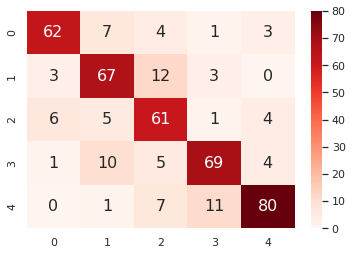

In [9]:

# variable donde guardamos nuestro modelo
modelRF = RandomForestClassifier(n_estimators = 1500, max_depth = 100, n_jobs = -1, criterion = 'entropy', min_samples_split = 3, warm_start = True) #0.8009367681498829
#modelRF = RandomForestClassifier(n_estimators = 100, n_jobs = -1, criterion = 'entropy', min_samples_split = 4) # 0.7892271662763466
#modelRF = RandomForestClassifier(n_estimators = 50, n_jobs = -1, criterion = 'gini', min_samples_split = 2)
'''
Creación de variables a partir de los que hemos tratado con smote con las que
entrenaremos nuestro modelo
'''
X_train_smote, X_validation_smote, Y_train_smote, Y_validation_smote = train_test_split(X_smote, Y_smote, test_size = 0.2, random_state = 42)

# Entrenamiento del modelo
modelRF.fit(X_train_smote, Y_train_smote)

# Predicciones realizadas por nuestro modelo

target_pred_smote = modelRF.predict(X_validation_smote)

# Resultados

array_smote = confusion_matrix(target_pred_smote, Y_validation_smote)

df_res_smote = pd.DataFrame(array_smote)

print(f"Puntuación f1_score de los datos tratados con smote:", f1_score( Y_validation_smote, target_pred_smote, average='micro'))
# Representación de la matriz

print(metrics.classification_report(target_pred_smote, Y_validation_smote))
sn.set(font_scale =1)
plt.show(sn.heatmap(df_res_smote, annot = True, annot_kws={'size':16}, cmap = 'Reds'))




### Evaluación de modelo

In [10]:

print(f"Puntuación f1_score de los datos tratados con smote:", f1_score( Y_validation_smote, target_pred_smote, average='micro'))


Puntuación f1_score de los datos tratados con smote: 0.7939110070257611


In [11]:
predict_prob_smote = modelRF.predict_proba(X_validation_smote)


In [12]:
print("Acierto Datos smote: ", accuracy_score(target_pred_smote, Y_validation_smote))

Acierto Datos smote:  0.7939110070257611


### Curva ROC Smote

#### A partir de ahora vamos a trabajar con los datos tratados con sobremuestreo smote

In [13]:
predict_prob_smote = modelRF.predict_proba(X_validation_smote)


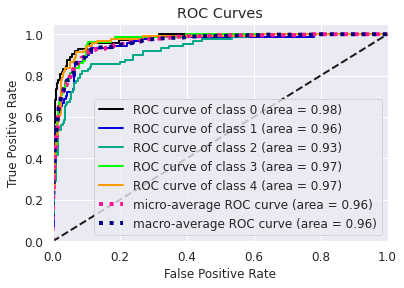

In [14]:
skplt.metrics.plot_roc(Y_validation_smote, predict_prob_smote)
plt.show()

## Pruebas


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
#Declaramos las variables que van a hiperparametrizarse
param_grid = [{'n_estimators': [100, 150, 200, 500, 1000, 1500],
               'criterion': ['gini','entropy'],
               'max_depth': [None, 50, 100, 200, 500],
               'min_samples_split': [2,3,4]}]

#scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'micro')
scoring = {'accuracy': make_scorer(accuracy_score),'f1': make_scorer(f1_score, average = 'micro')} #,'precision': make_scorer(precision_score, average = 'macro'),'recall': make_scorer(recall_score, average = 'macro')} #,'f1_macro': make_scorer(f1_score, average = 'macro','f1_weighted': make_scorer(f1_score, average = 'weighted')}
                                   
#Inicializamos la búsqueda grid
grid = GridSearchCV(modelRF, param_grid, cv = 5, n_jobs = -1, scoring = scoring, refit = 'f1', return_train_score = True)

#Entrenamos con los datos de entreno...
grid.fit(X_train_smote,Y_train_smote)

#Pintamos los resultados:
print("Mejores parámetros: ")
print(grid.best_params_)
print()
#print("Puntuaciones: ")
#print(grid.cv_results_['split3_test_f1'])

Mejores parámetros: 
{'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 100}



In [16]:
target_pred_grid_smote = grid.predict(X_validation_smote)


Puntuación f1_score de los datos tratados con smote: 0.7939110070257611
Puntuación f1_score de los datos tratados con smote_grid: 0.7915690866510539


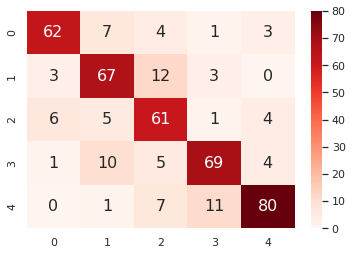

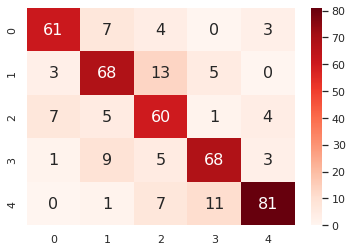

In [17]:
# Resultados

array_smote_grid = confusion_matrix(target_pred_grid_smote, Y_validation_smote)

df_res_smote_grid = pd.DataFrame(array_smote_grid)

rf_score = f1_score( Y_validation_smote, target_pred_smote, average='micro')
grid_score = f1_score( Y_validation_smote, target_pred_grid_smote, average='micro')

print(f"Puntuación f1_score de los datos tratados con smote: {rf_score}")
print(f"Puntuación f1_score de los datos tratados con smote_grid: {grid_score}")
#print(f"Puntuación f1_score de los datos tratados con smote:", f1_score( Y_validation_smote, target_pred_smote, average='micro'))
# Representación de la matriz

sn.set(font_scale =1)
plt.show(sn.heatmap(df_res_smote, annot = True, annot_kws={'size':16}, cmap = 'Reds'))
sn.set(font_scale =1)
plt.show(sn.heatmap(df_res_smote_grid, annot = True, annot_kws={'size':16}, cmap = 'Reds'))

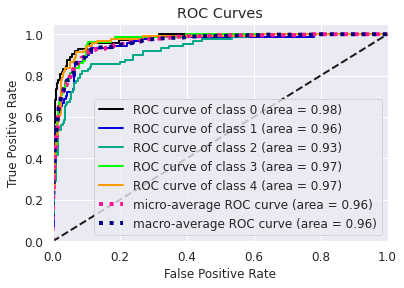

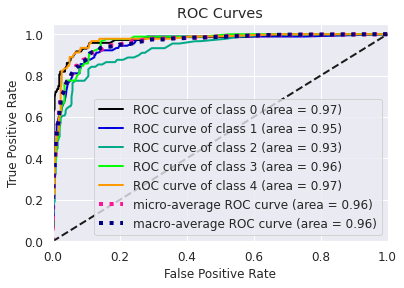

In [18]:
# muestra de los resultados de nuestra predicción de los modelos inicial e hiperparametrizados.
predict_prob_smote_grid = grid.predict_proba(X_validation_smote)
skplt.metrics.plot_roc(Y_validation_smote, predict_prob_smote)
plt.show()
skplt.metrics.plot_roc(Y_validation_smote, predict_prob_smote_grid)
plt.show()

In [19]:
# una vez entrenados los dos modelos, probamos su efectivadad y extraemos la mejor predicción
if grid_score > rf_score:

    final_predic = grid.predict(test)
    score= grid_score
    print('Modelo grid ha sido seleccionado')
else:
    final_predic = modelRF.predict(test)
    score = rf_score
    print('Modelo modelRF ha sido seleccionado')

Modelo modelRF ha sido seleccionado


In [20]:
# pasamos los resultados a un data frame
df_results = pd.DataFrame(final_predic, columns = ['final status'])

In [21]:
# guardamos los datos en formato csv para entregar los resultados de la predicción.
df_results.to_csv(f'predict_result-{score}.csv', index=False)